In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
from datetime import datetime  # For timestamps
import time  # Additional import that might be useful for delays
import numpy as np
from jetbot import Robot, Camera

In [2]:
#%pip install import-ipynb

In [3]:
#%pip install matplotlib

In [4]:
#%run ./functions_jetbot/linefollow.ipynb

In [5]:
#%pip install ipywidgets

In [6]:
#%pip install pyzbar

In [7]:
is_leader = False

In [8]:
import import_ipynb
import ipywidgets as widgets
from IPython.display import display

In [9]:
from functions_jetbot.linefollow import LineFollower, LineDetector, PIDController

Start


In [10]:
%run functions_jetbot/platoon_speed.ipynb

In [11]:
if is_leader:
    %run functions_jetbot/leader.ipynb

This JetBot is the Leader with IP: 192.168.1.12
Connected to broker successfully.


In [12]:
if not is_leader:
    %run functions_jetbot/follower.ipynb

In [13]:
# Creating objects
robot = Robot()
camera = Camera.instance (width=224, height=224)
follower = LineFollower(robot, camera,base_speed=0.4)

Received on platoon/followers: Acknowledged: move


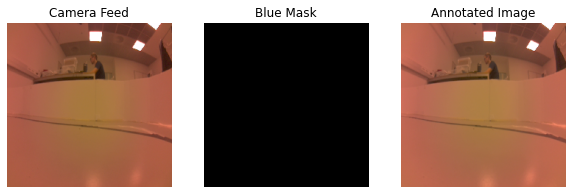

(False, None)

In [14]:
follower.detector.detect_large_blue_rectangle(debug=True)

In [15]:
### Task management with threads for final usage


import threading
import time

# Shared data and locks betwwen the tasks

shared_data = {
    'platoon_speed': 0.3,
    'UI_mqtt_data': None,  # Placeholder for UI data from other vehicles
    'qr_code_data': None,  # IP address of the vehicle in front
    'UI_local': {
        'running': False,
        'speed': 0.3,
        'adjusted_speed': 0.3,
        'is_following': False
        # Add other UI variables as needed
    },
}


# Locks for shared data
data_lock = threading.Lock()

def perform_steering(speed, start_motion):
    global shared_data
    # Acquire lock to read platoon_speed
    
    base_platoon_speed = shared_data['platoon_speed']
    # Your steering code here, using platoon_speed
    try:
        # Start line following
        shared_data["UI_local"]["is_following"] = follower.follow_line_single(speed, start_motion, mask_qr=True, follow_blue_rect=True)
    except Exception as e:
        print(f"Error: {e}")
    # Acquire lock to update steering_angle
    print(f"Steering task executed at {time.time()}")

def perform_platoonspeed_calculation():
    global shared_data
    # Call platoon speed calculation for this jetbot
    platoon_speed = shared_data["UI_local"]["speed"]
    if shared_data["UI_local"]["is_following"] is True:
        speed_adjust = adjust_speed()
    else:
        speed_adjust = 0
    shared_data["UI_local"]["adjusted_speed"] = platoon_speed + speed_adjust
    # Acquire lock to update platoon_speed 
    shared_data['platoon_speed'] = platoon_speed
    print(f"Speed calculation task executed at {time.time()}")
    
def perform_qrcode_extraction():
    global shared_data
    # Call qr code extraction here --> Niman
    time.sleep(0.05)
    # Acquire lock to update platoon_speed
    shared_data['qr_code_data'] = "192.168.1.33" # just an example
    print(f"qr code task executed at {time.time()}")

def perform_ui_mqtt():
    global shared_data
    # Acquire lock to read shared data
    
    platoon_speed = shared_data['platoon_speed']
    # Read other shared data as needed
    
    # Write necesarry data from UI to the shared variable for internal usage
    # ....
    if not is_leader:
        last_message = get_last_message()
        if last_message == "start":
            with data_lock:
                shared_data['UI_local']['running'] = True
        elif last_message == "stop":
            with data_lock:
                shared_data['UI_local']['running'] = False
        else:
            with data_lock:
                shared_data["UI_local"]["speed"] = float(last_message)
    # Your UI and MQTT code here, using steering_angle and platoon_speed
    print(f"UI and MQTT task executed at {time.time()}")

def steering_task():
    next_call = time.time()
    interval = 0.1  # 200ms
    while True:
        with data_lock:
            jetbot_speed = shared_data['UI_local']['adjusted_speed']
            print("Actual local speed:" + str(jetbot_speed))
            start = shared_data['UI_local']['running']
            try:
                print("Steering task running")
                perform_steering(jetbot_speed,start)
            except Exception as e:
                print(f"Error in steering task: {e}")
        
        next_call += interval
        sleep_time = next_call - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            print("Steering task is behind schedule!")
            next_call = time.time()

def platoonspeed_calculation_task():
    next_call = time.time()
    interval = 0.3  # 300ms
    while True:
        try:
            perform_platoonspeed_calculation()
        except Exception as e:
            print(f"Error in speed calculation task: {e}")
        next_call += interval
        sleep_time = next_call - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            print("Speed calculation task is behind schedule!")
            next_call = time.time()
            
def qrcode_extraction_task():
    next_call = time.time()
    interval = 0.5  # 500ms
    while True:
        try:
            perform_qrcode_extraction()
        except Exception as e:
            print(f"Error in Qrcode extraction task: {e}")
        next_call += interval
        sleep_time = next_call - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            print("Qrcode extraction task is behind schedule!")
            next_call = time.time()

def ui_mqtt_task():
    next_call = time.time()
    interval = 0.5  # 500ms
    while True:
        try:
            perform_ui_mqtt()
        except Exception as e:
            print(f"Error in UI and MQTT task: {e}")
        next_call += interval
        sleep_time = next_call - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            print("UI and MQTT task is behind schedule!")
            next_call = time.time()
            
            
# Create the UI elements
speed_slider = widgets.FloatSlider(
    value=0.3,
    min=0.15,
    max=0.6,
    step=0.01,
    description='Speed:',
    continuous_update=True
)

start_button = widgets.Button(description='Start')
stop_button = widgets.Button(description='Stop')

# Define the UI event handlers
def on_speed_change(change):
    if is_leader:
        publish_command(str(change['new'] + 0.03))
    with data_lock:
        shared_data['UI_local']['speed'] = change['new']
    print(f"Speed adjusted to {change['new']}")

def on_start_button_clicked(b):
    if is_leader:
        publish_command("start")
    with data_lock:
        shared_data['UI_local']['running'] = True
    print("Execution started")

def on_stop_button_clicked(b):
    if is_leader:
        publish_command("stop")
    with data_lock:
        shared_data['UI_local']['running'] = False
    print("Execution stopped")
    
# Connect the event handlers to the UI elements
speed_slider.observe(on_speed_change, names='value')
start_button.on_click(on_start_button_clicked)
stop_button.on_click(on_stop_button_clicked)

# Display the UI
display(speed_slider, start_button, stop_button)

FloatSlider(value=0.3, description='Speed:', max=0.6, min=0.15, step=0.01)

Button(description='Start', style=ButtonStyle())

Button(description='Stop', style=ButtonStyle())

In [16]:
if __name__ == "__main__":
    # Create threads for each task
    steering_thread = threading.Thread(target=steering_task)
    speed_thread = threading.Thread(target=platoonspeed_calculation_task)
    ui_mqtt_thread = threading.Thread(target=ui_mqtt_task)
    qr_thread = threading.Thread(target=qrcode_extraction_task)
    
    # Start the threads
    steering_thread.start()
    speed_thread.start()
    qr_thread.start()
    ui_mqtt_thread.start()

Actual local speed:0.3
Steering task running
big raod: 54.666666666666664
big road hough
Mode right line detected
Target angle: -116.4
Speed calculation task executed at 1733735679.5144017
steering angel: -9.106348506734157
Steering task executed at 1733735679.5336814


In [17]:
#camera.stop()
#robot.stop()

Actual local speed:0.3
Steering task running
qr code task executed at 1733735679.585111
big raod: 67.0
big road hough
Mode right line detected
Target angle: -115.5
steering angel: -8.919831281848857
Steering task executed at 1733735679.637941
UI and MQTT task executed at 1733735679.644181
Actual local speed:0.3
Steering task running
big raod: 66.8
big road hough
Mode right line detected
Target angle: -116.4
steering angel: -8.323082198382075
Steering task executed at 1733735679.7292473
Actual local speed:0.3
Steering task running
big raod: 65.8
big road hough
Mode right line detected
Target angle: -116.0
steering angel: -8.736719770436274Speed calculation task executed at 1733735679.8145807

Steering task executed at 1733735679.8238351
Actual local speed:0.3
Steering task running
big raod: 65.8
big road hough
Mode right line detected
Target angle: -115.5
steering angel: -8.940273614440677
Steering task executed at 1733735679.9375074
Actual local speed:0.3
Steering task running
small ra